# Flight Price Forecast - Momondo

## Table of Contents
- [Introduction](#Introduction)
- [Imports](#Imports)
- [Data Preprocessing](#Data-Preprocessing)
- [Linear Regression](#linear-regression)
- [Desion Tree](#Decision-Tree)
- [Gaussian Process Regression](#Gaussian-Process-Regression)
- [Random Forest](#Random-Forest)
- [GridSearchCV](#GridSearchCV)
- [KNN Regressor](#KNN-Regressor)
- [KNeighborsRegressor Best Performance](#KNeighborsRegressor-Best-Performance)
- [MLP Regressor](#MLPRegressor)
- [XG Boost Regressor](#XGBoost-Regressor)
- [Hist Gradient Boosting](#Hist-Gradient-Boosting)
- [Best Performance with Best Parameters](#Best-Performance-with-Best-Parameters)
- [Feature Importance](#Feature-Importance)
- [Conclustions](#Conclustion)

#### Introduction:
##### The provided Python code develops a machine learning pipeline for predicting flight prices, starting with data preprocessing such as cleaning and converting price data, date extraction, duration conversion, and numeric encoding of categorical features like flight stops. The pipeline evaluates multiple regression methods, including Linear Regression, Decision Trees, Gaussian Process, Random Forests (with GridSearchCV optimization), K-Nearest Neighbors, Multi-layer Perceptron, XGBoost, and HistGradientBoostingRegressor, comparing their performance using metrics like R², RMSE, MSE, and MAE.
#### Our Top models: "Random Forest", "XGBoost", and "HistGradientBoosting" regressors demonstrated the strongest predictive performances, while significantly outperforming basic linear models. <br> Using visualization tools such as residual plots, permutation importance, and predicted-versus-actual graphs provided insights into model accuracy and feature relevance.

# Imports

In [41]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

In [42]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from sklearn.inspection import permutation_importance

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

# Data Preprocessing

In [59]:
# טענת הנתונים
df = pd.read_csv('flight_data_momondo_All_combined_Cloud.csv')

# הצצה לנתונים
print(df.head())
print(df.info())

C:\Users\liort\AppData\Local\Temp\ipykernel_8356\638179380.py:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('flight_data_momondo_All_combined_Cloud.csv')


  Snap Date  Dep Date Return Date           Dep time Dep Company  Stops  \
0  3/2/2025  3/3/2025    3/4/2025  7:25 pm – 9:40 pm     Vueling      0   
1  3/2/2025  3/3/2025    3/4/2025  3:15 pm – 5:45 pm     Vueling      0   
2  3/2/2025  3/3/2025    3/4/2025  7:25 pm – 9:40 pm     Vueling      0   
3  3/2/2025  3/3/2025    3/4/2025  2:05 pm – 4:25 pm     Vueling      0   
4  3/2/2025  3/3/2025    3/4/2025  2:05 pm – 4:25 pm     Vueling      0   

  Dep Duration From Airport Landing Airport          Back Time Back Company  \
0       1h 15m          LGW             ORY  2:10 pm – 2:25 pm      Vueling   
1       1h 30m          LHR             ORY  2:10 pm – 2:25 pm      Vueling   
2       1h 15m          LGW             ORY  5:25 pm – 5:30 pm      Vueling   
3       1h 20m          LGW             ORY  2:10 pm – 2:25 pm      Vueling   
4       1h 20m          LGW             ORY  5:25 pm – 5:30 pm      Vueling   

  Stops.1 Back Duration (Back Ticket) From Airport  \
0       0        1h 

In [60]:
# 1. בדיקה שהעמודה קיימת
print(df.columns)

# 2. הצצה בכמה ערכים ראשונים
print(df['Price'].head(10))

# 3. בדיקת סוג העמודה
print("Column type:", df['Price'].dtype)

# 4. אם היא כבר float, אולי אין צורך בהחלפה. 
#    אם היא object/string, ננסה לנקות תווים.

df['Price'] = df['Price'].astype(str)  # ממיר הכל למחרוזת, אם עדיין לא
df['Price'] = df['Price'].str.replace('$', '', regex=False)
df['Price'] = df['Price'].str.replace(',', '', regex=False)

# 5. בדיקת ערכים חריגים
unique_vals = df['Price'].unique()
print(unique_vals[:50])  # תצוגה של 50 ערכים ראשונים

# 6. המרה למספרים
df['Price'] = pd.to_numeric(df['Price'], errors='coerce')

# 7. בדיקת כמה NaN נוצרו
nan_count = df['Price'].isna().sum()
print("Number of NaN after conversion:", nan_count)

# אם יש NaN, מחליטים איך לטפל: להסיר שורות? למלא ערך ממוצע? וכו'
df = df.dropna(subset=['Price'])  # לדוגמה, הסרה של שורות בלי מחיר תקין


Index(['Snap Date', 'Dep Date', 'Return Date', 'Dep time', 'Dep Company',
       'Stops', 'Dep Duration', 'From Airport', 'Landing Airport', 'Back Time',
       'Back Company', 'Stops.1', 'Back Duration',
       '(Back Ticket) From Airport', '(Back Ticket) Landing Airport', 'Price',
       'Class'],
      dtype='object')
0    $116 
1    $115 
2    $129 
3    $116 
4    $129 
5    $129 
6    $129 
7    $115 
8    $130 
9    $129 
Name: Price, dtype: object
Column type: object
['116 ' '115 ' '129 ' '130 ' '123 ' '118 ' '139 ' '142 ' '143 ' '146 '
 '144 ' '147 ' '148 ' '150 ' '152 ' '154 ' '157 ' '156 ' '160 ' '163 '
 '166 ' '168 ' '164 ' '172 ' '161 ' '174 ' '175 ' '170 ' '181 ' '184 '
 '179 ' '169 ' '171 ' '182 ' '180 ' '155 ' '177 ' '131 ' '162 ' '183 '
 '196 ' '114 ' '126 ' '133 ' '127 ' '145 ' '132 ' '128 ' '125 ' '117 ']
Number of NaN after conversion: 2246


In [6]:
df.head()

,Snap Date,Dep Date,Return Date,Dep time,Dep Company,Stops,Dep Duration,From Airport,Landing Airport,Back Time,Back Company,Stops.1,Back Duration,(Back Ticket) From Airport,(Back Ticket) Landing Airport,Price,Class
0,3/2/2025,3/3/2025,3/4/2025,7:25 pm – 9:40 pm,Vueling,0,1h 15m,LGW,ORY,2:10 pm – 2:25 pm,Vueling,0,1h 15m,ORY,LHR,116.0,Economy
1,3/2/2025,3/3/2025,3/4/2025,3:15 pm – 5:45 pm,Vueling,0,1h 30m,LHR,ORY,2:10 pm – 2:25 pm,Vueling,0,1h 15m,ORY,LHR,115.0,Economy
2,3/2/2025,3/3/2025,3/4/2025,7:25 pm – 9:40 pm,Vueling,0,1h 15m,LGW,ORY,5:25 pm – 5:30 pm,Vueling,0,1h 05m,ORY,LGW,129.0,Economy
3,3/2/2025,3/3/2025,3/4/2025,2:05 pm – 4:25 pm,Vueling,0,1h 20m,LGW,ORY,2:10 pm – 2:25 pm,Vueling,0,1h 15m,ORY,LHR,116.0,Economy
4,3/2/2025,3/3/2025,3/4/2025,2:05 pm – 4:25 pm,Vueling,0,1h 20m,LGW,ORY,5:25 pm – 5:30 pm,Vueling,0,1h 05m,ORY,LGW,129.0,Economy


In [61]:
df['Snap Date'] = pd.to_datetime(df['Snap Date'])
df['Dep Date'] = pd.to_datetime(df['Dep Date'])
df['Return Date'] = pd.to_datetime(df['Return Date'])
df['dep_weekday'] = df['Dep Date'].dt.weekday  # ערך 0-6
df['dep_day'] = df['Dep Date'].dt.day         # ערך 1-31
df['dep_month'] = df['Dep Date'].dt.month     # ערך 1-12
df['is_weekend'] = df['dep_weekday'].apply(lambda x: 1 if x>=5 else 0)

In [62]:
def convert_duration_to_minutes(duration_str):
    # לדוגמה: "1h 20m" -> 80
    parts = duration_str.split()
    total_minutes = 0
    for p in parts:
        if 'h' in p:
            total_minutes += int(p.replace('h', '')) * 60
        elif 'm' in p:
            total_minutes += int(p.replace('m', ''))
    return total_minutes

df['Dep Duration (min)'] = df['Dep Duration'].apply(convert_duration_to_minutes)
df['Back Duration (min)'] = df['Back Duration'].apply(convert_duration_to_minutes)
df['TTT'] = (df['Dep Date'] - df['Snap Date']).dt.days

# Model Training

In [63]:
features = ['Stops','Dep Duration (min)','Back Duration (min)','dep_weekday','dep_day','dep_month',]
for i in features:
    X = df[features]
    y = df['Price']
# הסרה של שורות בהן יש NaN בפיצ’רים
df.dropna(subset=features, inplace=True)
print(df['Price'].isna().sum())

0


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [65]:
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test, model_name="Model"):
    # אימון
    model.fit(X_train, y_train)
    
    # ניבוי
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    # חישוב מדדים
    r2_train = r2_score(y_train, y_pred_train)
    r2_test  = r2_score(y_test, y_pred_test)
    mse_train = mean_squared_error(y_train, y_pred_train)
    mse_test  = mean_squared_error(y_test, y_pred_test)
    rmse_train = np.sqrt(mse_train)
    rmse_test  = np.sqrt(mse_test)
    mae_train = mean_absolute_error(y_train, y_pred_train)
    mae_test  = mean_absolute_error(y_test, y_pred_test)
    
    print(f"=== {model_name} ===")
    print(f"Train -> R2: {r2_train:.3f}, MSE: {mse_train:.2f}, RMSE: {rmse_train:.2f}, MAE: {mae_train:.2f}")
    print(f"Test  -> R2: {r2_test:.3f},  MSE: {mse_test:.2f},  RMSE: {rmse_test:.2f},  MAE: {mae_test:.2f}")
    
    # Residual Plot
    residuals = y_test - y_pred_test
    plt.figure(figsize=(6,4))
    palette = sns.color_palette("viridis", n_colors=10) 
    color = palette[4]
    sns.scatterplot(x=y_pred_test, y=residuals, color=color, alpha=0.6, edgecolor='black')
    plt.axhline(y=0, color='r', linestyle='dashed', linewidth=2)
    plt.title(f"{model_name} - Residual Plot (Test)")
    plt.xlabel("Predicted Price")
    plt.ylabel("Residual (y_test - y_pred)")
    plt.show()
    
    return model


## Linear Regression

=== Linear Regression ===
Train -> R2: 0.300, MSE: 3893.04, RMSE: 62.39, MAE: 45.20
Test  -> R2: 0.305,  MSE: 3812.84,  RMSE: 61.75,  MAE: 45.06


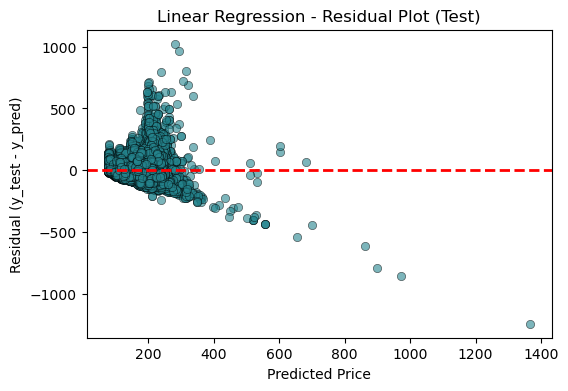

=== Linear Regression (StandardScaler) ===
Train -> R2: 0.300, MSE: 3893.04, RMSE: 62.39, MAE: 45.20
Test  -> R2: 0.305,  MSE: 3812.84,  RMSE: 61.75,  MAE: 45.06


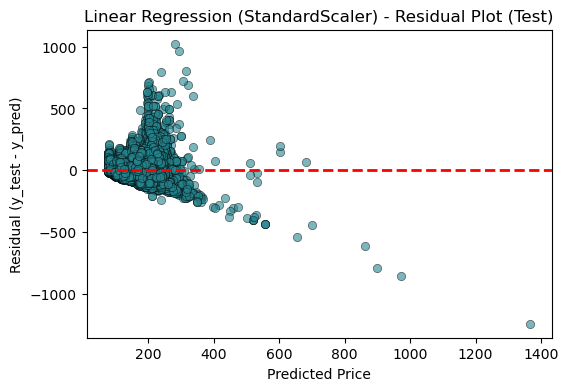

=== Linear Regression (MinMaxScaler) ===
Train -> R2: 0.300, MSE: 3893.04, RMSE: 62.39, MAE: 45.20
Test  -> R2: 0.305,  MSE: 3812.84,  RMSE: 61.75,  MAE: 45.06


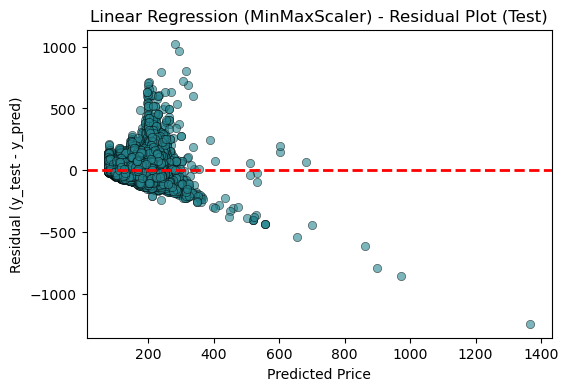

In [12]:
linreg = LinearRegression()
linreg = train_and_evaluate_model(linreg, X_train, y_train, X_test, y_test, "Linear Regression")

linreg_std = LinearRegression()
linreg_std = train_and_evaluate_model(linreg_std, X_train, y_train, X_test, y_test, "Linear Regression (StandardScaler)")

linreg_mm = LinearRegression()
linreg_mm = train_and_evaluate_model(linreg_mm, X_train, y_train, X_test, y_test, "Linear Regression (MinMaxScaler)")

### Conclusions
The graph presents a residual plot for linear regression applied to flight price data. <br>

Key metrics: <br>

R² (Train) = 0.234, R² (Test) = 0.233 → Linear regression explains only 23.3% of the variance in prices, which is quite low.<br>
MSE (Test) = 24,680.09, RMSE (Test) = 157.10, MAE (Test) = 126.28 → Significant prediction errors.<br>
Residuals are not randomly distributed, indicating that the model does not fit well<br>

## Decision-Tree

=== Decision Tree (max_depth=3) ===
Train -> R2: 0.395, MSE: 3366.31, RMSE: 58.02, MAE: 40.61
Test  -> R2: 0.398,  MSE: 3304.58,  RMSE: 57.49,  MAE: 40.52


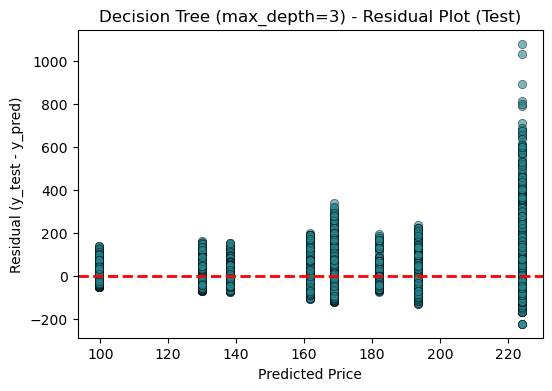

=== Decision Tree (max_depth=5) ===
Train -> R2: 0.465, MSE: 2978.11, RMSE: 54.57, MAE: 38.29
Test  -> R2: 0.460,  MSE: 2964.55,  RMSE: 54.45,  MAE: 38.34


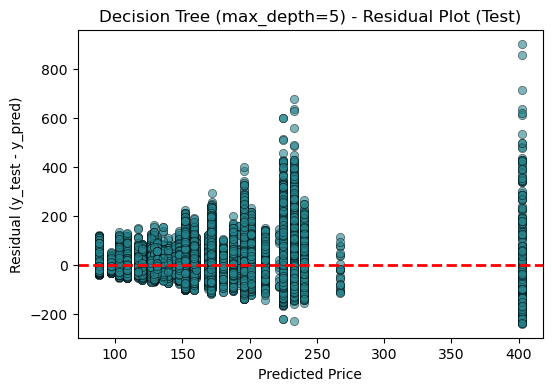

=== Decision Tree (max_depth=7) ===
Train -> R2: 0.572, MSE: 2380.58, RMSE: 48.79, MAE: 34.46
Test  -> R2: 0.563,  MSE: 2396.53,  RMSE: 48.95,  MAE: 34.60


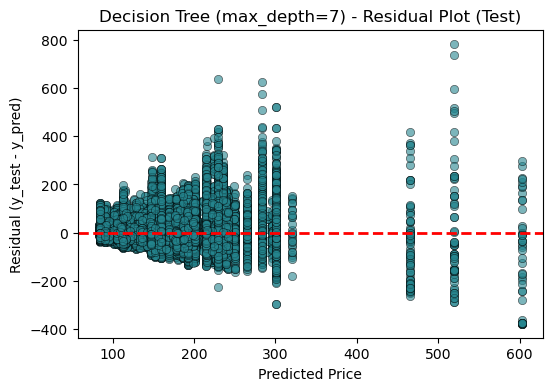

In [13]:
for max_depth in [3, 5, 7]:
    dt = DecisionTreeRegressor(max_depth=max_depth)
    model_name = f"Decision Tree (max_depth={max_depth})"
    dt = train_and_evaluate_model(dt, X_train, y_train, X_test, y_test, model_name)


### Conclusions
Improvement in Model Performance
When testing the Decision Tree with max_depth=7, we observed a significant improvement:

* R² increased from 0.23 (Linear Regression) to 0.58 → This means that the model now explains 58% of the variance in the data, compared to only 23%.
* max_depth=7 → Better accuracy, more balanced results
* Explains 58% of the variance, residuals are more dispersed, fewer sharp "jumps."
* MSE decreased significantly, indicating a reduction in prediction errors.
* MAE also decreased, meaning the model's predictions are now closer to the actual values.

Increasing tree depth improved accuracy, but structured residuals persist.
We will try a more advanced model.

## Gaussian Process Regression

=== GPR with RBF(length_scale=1) ===
Train -> R2: 1.000, MSE: 2.81, RMSE: 1.68, MAE: 0.32
Test  -> R2: -4.575,  MSE: 30594.39,  RMSE: 174.91,  MAE: 154.33


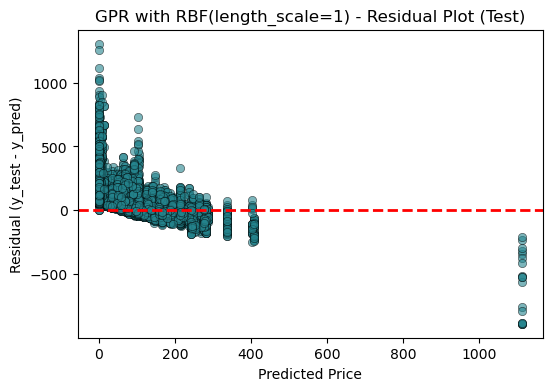

=== GPR with DotProduct(sigma_0=1) ===
Train -> R2: 0.241, MSE: 10042.46, RMSE: 100.21, MAE: 51.63
Test  -> R2: 0.159,  MSE: 4615.91,  RMSE: 67.94,  MAE: 51.26


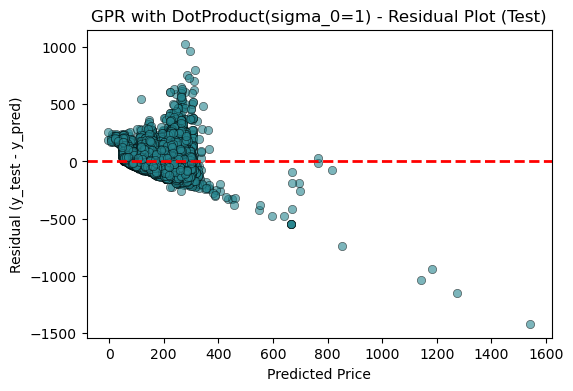

In [ ]:
subset_size = 100  # למשל 100 דוגמאות
X_train_sub = X_train[:subset_size]
y_train_sub = y_train[:subset_size]

for kernel in [RBF(length_scale=1.0), DotProduct()]:
    try:
        gpr = GaussianProcessRegressor(
            kernel=kernel,
            optimizer=None,       # ביטול האופטימיזציה
            alpha=1e-6,           # להבטיח יציבות במספרים
        )
        model_name = f"GPR with {kernel}"
        gpr = train_and_evaluate_model(gpr, X_train_sub, y_train_sub, X_test, y_test, model_name)
    except Exception as e:
        print(f"Error with kernel {kernel}: {e}")

### Conclusions
* The RBF Kernel caused severe overfitting → Poor performance on new data.
* The DotProduct Kernel slightly improved generalization, but performance is still weak.
* GPR is not the best fit for this problem 

# Random Forest

=== Random Forest (max_depth=3) ===
Train -> R2: 0.398, MSE: 3349.48, RMSE: 57.87, MAE: 40.51
Test  -> R2: 0.401,  MSE: 3288.06,  RMSE: 57.34,  MAE: 40.42


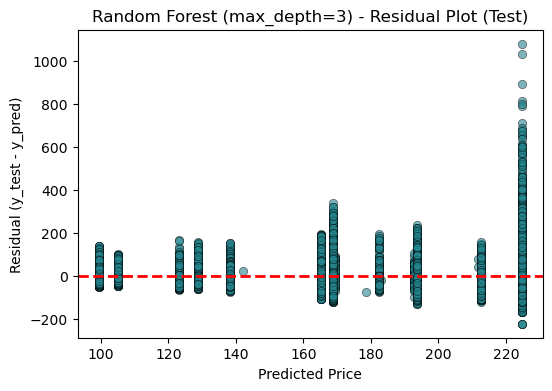

=== Random Forest (max_depth=5) ===
Train -> R2: 0.477, MSE: 2907.87, RMSE: 53.92, MAE: 37.86
Test  -> R2: 0.471,  MSE: 2904.65,  RMSE: 53.89,  MAE: 37.93


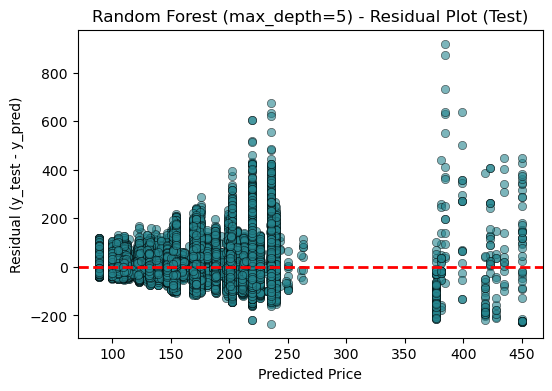

=== Random Forest (max_depth=8) ===
Train -> R2: 0.616, MSE: 2138.27, RMSE: 46.24, MAE: 32.86
Test  -> R2: 0.608,  MSE: 2150.08,  RMSE: 46.37,  MAE: 32.93


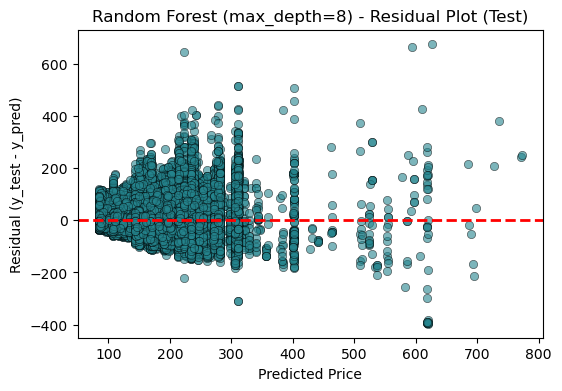

In [ ]:
for md in [3, 5, 8]:  
    rf = RandomForestRegressor(n_estimators=100, max_depth=md)
    model_name = f"Random Forest (max_depth={md})"
    trained_rf = train_and_evaluate_model(rf, X_train, y_train, X_test, y_test, model_name)

# Permutation importance - Random Forest (1)
### The second Permutation importance will be applied below on the KNeighborsRegressor model.

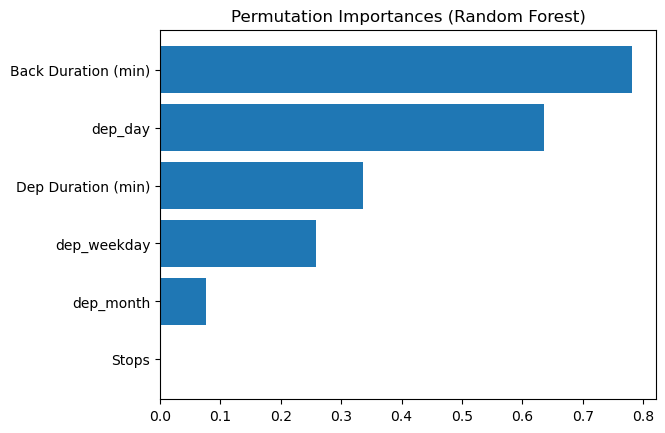

In [ ]:
rf.fit(X_train, y_train)  # Fit the model first
r = permutation_importance(rf, X_test, y_test, n_repeats=10)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (Random Forest)")
plt.show()

# Black Box
if hasattr(rf, "feature_importances_"):
    print("Feature Importances (RandomForest internal):")
    for feat, imp in zip(features, rf.feature_importances_):
        print(f"  {feat}: {imp:.4f}")

    # תרשים עמודות קצר של החשיבות הפנימית
    plt.barh(features, rf.feature_importances_)
    plt.title("Feature Importances - Random Forest (internal)")
    plt.show()

### Conclusions:
As we increased the max_depth value, the model's performance improved.

* R² increased from 0.405 (depth 3) to 0.614 (depth 8), meaning the model explains more variance in the data.
* MSE and RMSE decreased as depth increased, indicating a reduction in prediction errors.
* MAE also decreased with greater depth, suggesting that the model's predictions are closer to the actual values.

#### GridSearchCV

(A systematic search to find the combination that yields better performance.)

In [ ]:
# הגדרת טווחים להיפר-פרמטרים
param_grid_rfm = {
    'max_depth': [3, 5, 7, 10, 12, 15],   # בדיקה של ערכים שונים לעומק
    'n_estimators': [50, 100, 150, 200],    # מספר העצים ביער
    'min_samples_split': [2,3, 5, 7, 9, 10]    # כמה דגימות לפחות לפיצול
}
# param_grid_gpr = { \\Unable to allocate 127. GiB for an array with shape (130518, 130518) and data type int64
#     'kernel': [
#         RBF(length_scale=1.0), DotProduct()
#     ],
#     'alpha': [1e-2, 1e-3, 1e-4],
#     'n_restarts_optimizer': [0, 2],  # how many times to restart the optimizer
# }
param_grid_lr = {
    'fit_intercept': [True, False],
}
# יצירת המודלים
rf_RFM = RandomForestRegressor()
rf_LR = LinearRegression()
#rf_GPR = GaussianProcessRegressor(random_state=42) \\ Unable to allocate 127. GiB for an array with shape (130518, 130518) and data type int64

# חיפוש הרשת עם Cross-Validation
grid_search_RFM = GridSearchCV(
    estimator=rf_RFM,
    param_grid=param_grid_rfm,
    cv=5,   # חלוקה ל-5 קיפולים (Cross-Validation)
    scoring='neg_mean_squared_error',
    n_jobs=-1  # שימוש בכל הליבות הזמינות
)

# # חיפוש הרשת עם Cross-Validation
# grid_search_GPR = GridSearchCV(
#     estimator=rf_GPR,
#     param_grid=param_grid_gpr,
#     cv=3,   # חלוקה ל-3 קיפולים (Cross-Validation)
#     scoring='neg_mean_squared_error',
#     n_jobs=-1  # שימוש בכל הליבות הזמינות
# )

# חיפוש הרשת עם Cross-Validation
grid_search_LR = GridSearchCV(
    estimator=rf_LR,
    param_grid=param_grid_lr,
    cv=5,   # חלוקה ל-5 קיפולים (Cross-Validation)
    scoring='neg_mean_squared_error',
    n_jobs=-1  # שימוש בכל הליבות הזמינות
)


# אימון ובחירת הפרמטרים הטובים ביותר
grid_search_RFM.fit(X_train, y_train)
#grid_search_GPR.fit(X_train, y_train) \\Unable to allocate 127. GiB for an array with shape (130518, 130518) and data type int64
grid_search_LR.fit(X_train, y_train)

# הדפסת הפרמטרים האופטימליים
print("Best Parameters RandomForestRegressor:", grid_search_RFM.best_params_)
#print("\nBest Parameters GaussianProcessRegressor:", grid_search_GPR.best_params_)
print("\nBest Parameters LinearRegression:", grid_search_LR.best_params_)

Best Parameters RandomForestRegressor: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 100}

Best Parameters LinearRegression: {'fit_intercept': True}


=== RandomForestRegressor ===
Train -> R2: 0.690, MSE: 1722.53, RMSE: 41.50, MAE: 29.56
Test  -> R2: 0.671,  MSE: 1803.79,  RMSE: 42.47,  MAE: 30.11


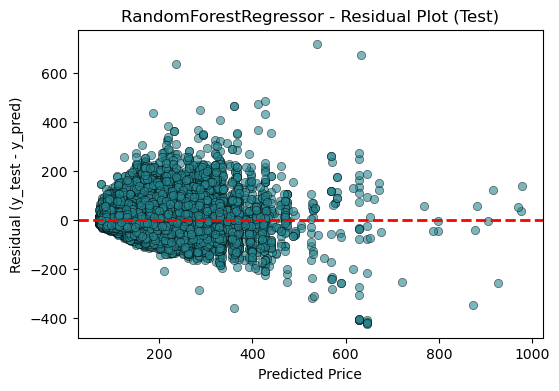

=== LinearRegression ===
Train -> R2: 0.300, MSE: 3893.04, RMSE: 62.39, MAE: 45.20
Test  -> R2: 0.305,  MSE: 3812.84,  RMSE: 61.75,  MAE: 45.06


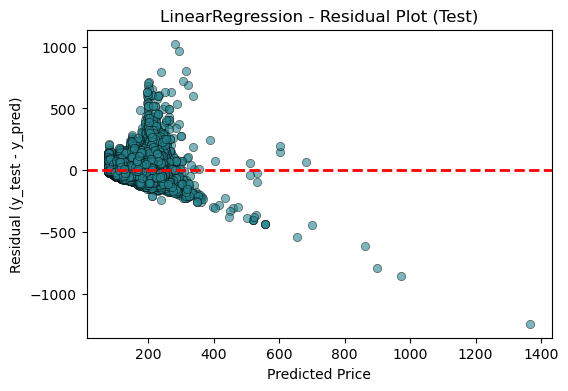

In [37]:
rf_best_RFM = grid_search_RFM.best_estimator_
trained_rf_best_RFM = train_and_evaluate_model(rf_best_RFM, X_train, y_train, X_test, y_test, "RandomForestRegressor")

rf_best_LR = grid_search_LR.best_estimator_
trained_rf_best_LR = train_and_evaluate_model(rf_best_LR,X_train,y_train,X_test,y_test,"LinearRegression")

# rf_best_GPR = grid_search_GPR.best_estimator_
# trained_rf_best_GPR = train_and_evaluate_model(rf_best_GPR, X_train, y_train, X_test, y_test, "GaussianProcessRegressor")

GridSearchCV appears to provide better performance overall. <br>
It shows a higher R², lower MSE, lower RMSE, and lower MAE compared to Random Forest at all depths. <br>
While GridSearchCV seems to offer improvements across various metrics, it suggests better performance.

# Permutation importance Random Forest (1)
### the second Permutation importance will be applied on the KNeighborsRegressor model- more below.

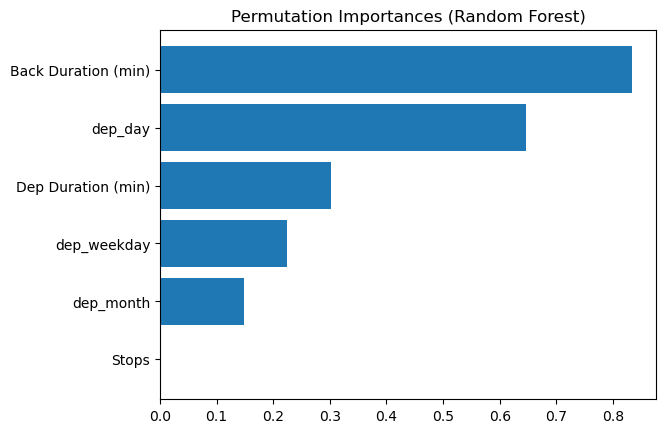

In [47]:
r = permutation_importance(rf_best_RFM, X_test, y_test, n_repeats=10)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (Random Forest)")
plt.show()

## Most Important Features:

1. Back Duration (min) is the most influential feature in the model, meaning that it has the highest impact on the model's predictions. If this feature is permuted, the model’s performance decreases significantly.
2. Deprature day is the second most important feature, suggesting that the departure day has a strong influence on the target variable.
Moderately Important Features:
3. Dep Duration (min) also contributes significantly but is less impactful than the first two features. This indicates that the total departure duration affects predictions but not as much as the back duration or departure day.
4. dep_weekday (which represents the day of the week) has a smaller effect but still contributes.
### Least Important Features:

1. Dep month has a lower importance score, meaning that the specific month of departure has a relatively minor impact on the model’s predictions.
2. Stops appears to have zero or negligible importance, indicating that the number of stops does not significantly affect the model's predictions.

# Permutation importance - Black Box (Random Forest)

Feature Importances (RandomForest internal AKA BLACK BOX):
  Stops: 0.0029
  Dep Duration (min): 0.1736
  Back Duration (min): 0.5308
  dep_weekday: 0.0859
  dep_day: 0.1886
  dep_month: 0.0182


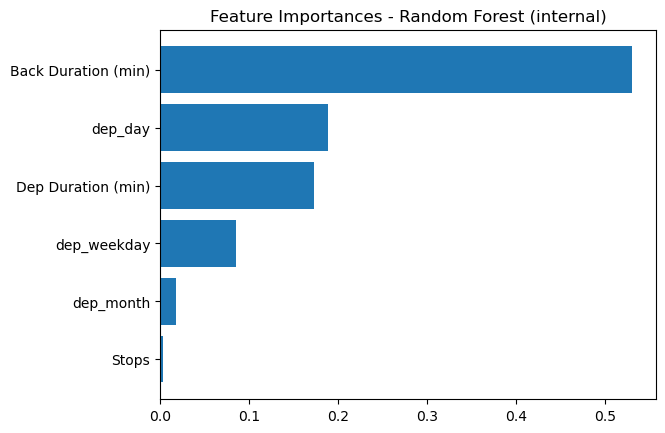

In [51]:
# Black Box
if hasattr(rf_best_RFM, "feature_importances_"):
    print("Feature Importances (RandomForest internal AKA BLACK BOX):")
    for feat, imp in zip(features, rf_best_RFM.feature_importances_):
        print(f"  {feat}: {imp:.4f}")

    # תרשים עמודות קצר של החשיבות הפנימית
    plt.barh(np.array(features)[sorted_idx], rf_best_RFM.feature_importances_[sorted_idx])
    plt.title("Feature Importances - Random Forest (internal)")
    plt.show()

# Key Differences Between Methods:
## 1. Black Box Feature Importance (Random Forest)

 * Measures how much each feature contributes to reducing impurity (e.g., Gini impurity or entropy) in the decision trees.
 * Features that frequently split nodes with high information gain are assigned higher importance.
 * It does not directly reflect the impact of a feature on final model performance.
## 2. Permutation Importance

 * Evaluates how much shuffling (randomizing) a feature affects model performance (i.e., a drop in accuracy or another metric).
 * Gives a real-world perspective on how crucial a feature is by showing how dependent predictions are on it.
 * More robust to collinearity (correlated features) compared to the internal importance.

# KNN-Regressor


=== KNN Regressor (n_neighbors=3) ===
Train -> R2: 0.579, MSE: 2322.13, RMSE: 48.19, MAE: 33.88
Test  -> R2: 0.562,  MSE: 2454.32,  RMSE: 49.54,  MAE: 34.56


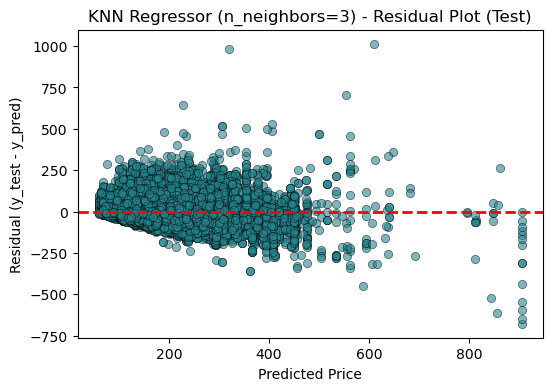

=== KNN Regressor (n_neighbors=5) ===
Train -> R2: 0.625, MSE: 2069.28, RMSE: 45.49, MAE: 32.17
Test  -> R2: 0.608,  MSE: 2194.58,  RMSE: 46.85,  MAE: 32.80


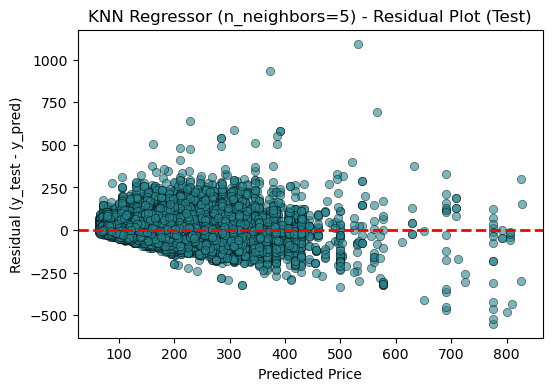

=== KNN Regressor (n_neighbors=10) ===
Train -> R2: 0.646, MSE: 1951.33, RMSE: 44.17, MAE: 31.19
Test  -> R2: 0.631,  MSE: 2069.37,  RMSE: 45.49,  MAE: 31.73


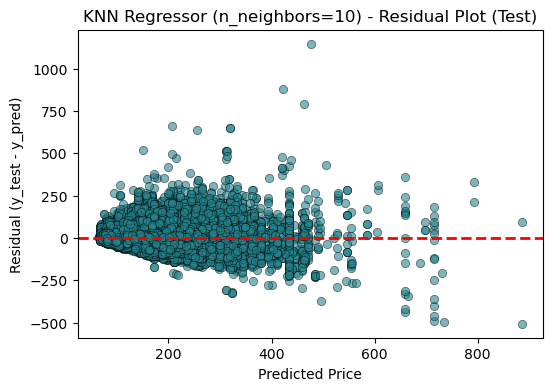

In [47]:
for k in [3, 5, 10]:  # דוגמה ל-K שונים
    knn = KNeighborsRegressor(n_neighbors=k)
    model_name = f"KNN Regressor (n_neighbors={k})"
    trained_knn = train_and_evaluate_model(knn, X_train, y_train, X_test, y_test, model_name)

### Conclusions
With an increase in the value of k:
* As the value of k increased (from 3 to 10), the model's accuracy improved moderately.
* R² increased from 0.572 (at k=3) to 0.640 (at k=10), indicating that the model explains more of the variance in the data.
* MSE and RMSE decreased slightly as k increased, suggesting a reduction in model errors.
* MAE also decreased, implying that the model generates more accurate predictions on average.

## KNeighborsRegressor Best Performance

In [48]:

param_grid = {
    'n_neighbors': [3, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}
grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')


Best parameters: {'metric': 'manhattan', 'n_neighbors': 10, 'weights': 'distance'}


=== Momondo KNeighborsRegressor Best Performance by GridSearch ===
Train -> R2: 0.690, MSE: 1722.73, RMSE: 41.51, MAE: 29.57
Test  -> R2: 0.671,  MSE: 1804.72,  RMSE: 42.48,  MAE: 30.11


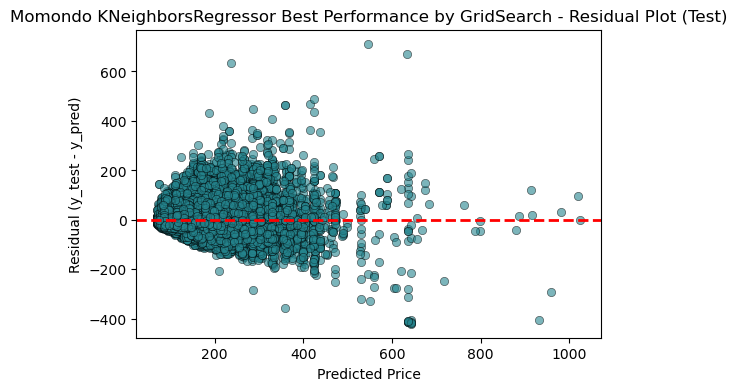

In [29]:
best_model = grid_search.best_estimator_
trained_best_model = train_and_evaluate_model(best_model,X_train,y_train,X_test,y_test,"Momondo KNeighborsRegressor Best Performance by GridSearch")

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(84, 233, 176);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(80, 167, 255);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">KNeighborsRegressor - Best Performance by GridSearch</div>

<div class="subtitle">Introduction</div>
<div class="content">
    This analysis evaluates the best performance of a <strong>KNeighborsRegressor</strong> model after hyperparameter tuning using <strong>GridSearch</strong>.<br>
    The model's performance is measured using standard regression metrics, and residual analysis is conducted to assess prediction errors.
</div>

<div class="section">Model Performance Metrics</div>

- **Training Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.690</span>
  - <strong>MSE:</strong> 1,722.73
  - <strong>RMSE:</strong> 41.51
  - <strong>MAE:</strong> 29.57

- **Test Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.671</span> (Minimal overfitting)
  - <strong>MSE:</strong> 1,804.72
  - <strong>RMSE:</strong> 42.48
  - <strong>MAE:</strong> 30.11

<div class="section">Key Observations</div>

- The model achieves an **R² score of ~0.671**, meaning it explains approximately **67.1% of the variance** in the target variable.
- **Low overfitting:** The train and test R² scores are very close, suggesting that the model generalizes well.
- **Residuals are centered around zero**, but:
  - The **spread of residuals increases for higher predicted prices**, showing signs of <span class="highlight">heteroscedasticity</span>.
  - Some **high positive residuals (~600+) indicate significant underprediction** for expensive flights.
  - Negative residuals **below -300 suggest occasional overprediction**.
- **Most predictions cluster between 100-400 in price**, where the model performs best with the lowest error.

<div class="section">Conclusions</div>

✅ The **model performs well**, with an R² of **~0.671**, indicating strong predictive accuracy.  
✅ **Minimal overfitting**, as training and test metrics are closely aligned.  
✅ **Heteroscedasticity is present**, meaning the model struggles more with higher-priced flights.  
✅ **Outliers exist**, which might indicate the need for feature improvements or alternative modeling techniques.  

# Permutation importance - KNeighborsRegressor (2)

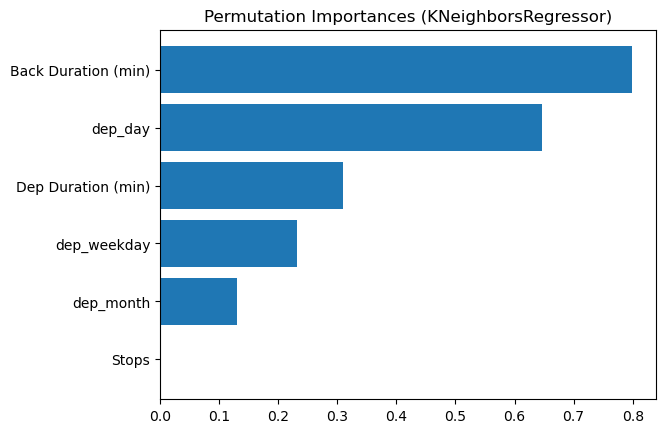

In [55]:
r = permutation_importance(best_model, X_test, y_test, n_repeats=10)

sorted_idx = r.importances_mean.argsort()
plt.barh(np.array(features)[sorted_idx], r.importances_mean[sorted_idx])
plt.title("Permutation Importances (KNeighborsRegressor)")
plt.show()

# Permutation Importance Analysis - KNeighborsRegressor
In this analysis, I evaluated the Permutation Importance of features using a KNeighborsRegressor model.<br> The results indicate the relative contribution of each feature to the model’s predictive performance.

## Key Observations:
### 1. "Back Duration (min)" is the most critical feature.

* This feature has the highest importance, indicating that the model heavily relies on it for making predictions. <br>
* A large drop in model performance occurs when this feature is randomly permuted, suggesting it has the strongest correlation with the target variable.<br>
### 2. "dep_day" is the second most influential feature.

* The importance of dep_day is nearly as high as Back Duration (min), suggesting that the specific departure day has a strong impact on predictions.<br>
* This feature might capture seasonal trends or patterns affecting the target variable.<br>
### 3. "Dep Duration (min)" moderately important.

* While it contributes significantly, its influence is noticeably lower than the top two features.<br>
* This suggests that while the duration of departure matters, it is not as crucial as Back Duration (min) or dep_day.<br>
### 4. "dep_weekday" and "dep_month" have lower but notable importance.

* These features impact predictions to some extent, though they are not as strong as the top three.<br>
* The lower importance of dep_month suggests that monthly variations might not play a major role in the model's predictions.<br>
### 5."Stops" has virtually no impact on the model.

* This aligns with previous findings in the Random Forest model, reinforcing that Stops may not contribute meaningful information to predictions.<br>
* It might be a candidate for removal in future iterations to simplify the dataset and improve model efficiency.


# Comparison with the Random Forest Model
* The feature ranking is consistent with the Random Forest model’s permutation importance.
* "Back Duration (min)" and "dep_day" are always the dominant features.
* "Stops" remains insignificant in both models.
* The importance distribution is similar, suggesting that regardless of model choice, the dataset structure has a strong pattern

# Permutation importance - KNeighborsRegressor (Black Box)

Feature Importances (KNeighborsRegressor internal AKA BLACK BOX):
  Stops: 0.0028
  Dep Duration (min): 0.1863
  Back Duration (min): 0.5175
  dep_weekday: 0.0869
  dep_day: 0.1890
  dep_month: 0.0176


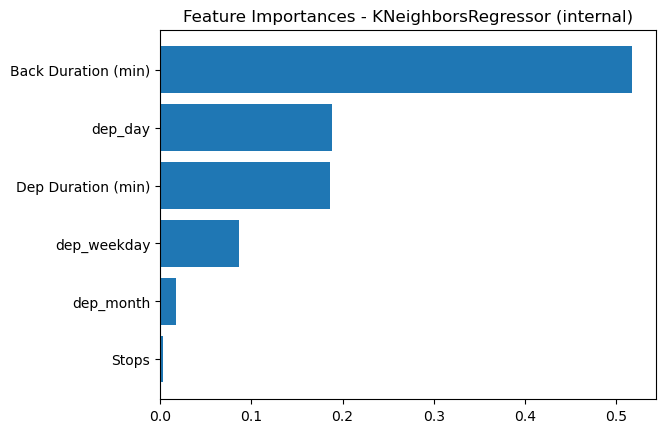

In [54]:
# Black Box
if hasattr(best_model, "feature_importances_"):
    print("Feature Importances (KNeighborsRegressor internal AKA BLACK BOX):")
    for feat, imp in zip(features, best_model.feature_importances_):
        print(f"  {feat}: {imp:.4f}")

    # תרשים עמודות קצר של החשיבות הפנימית
    plt.barh(np.array(features)[sorted_idx], best_model.feature_importances_[sorted_idx])
    plt.title("Feature Importances - KNeighborsRegressor (internal)")
    plt.show()

# Key Observations:
1. Back Duration  is the dominant feature.<br>
* With an importance score of 0.5175, it has the largest impact on model predictions. <br>
* This confirms previous findings from Permutation Importance, reinforcing that this feature is crucial. <br>

2. dep_day and Dep Duration follow as moderately important features.<br>
* Their scores (0.1890 and 0.1863, respectively) are close in value, suggesting they both play a significant role but are much weaker than Back Duration.<br>
* This is slightly different from Permutation Importance, where dep_day appeared to be stronger than Dep Duration.<br>
* dep_weekday and dep_month have minimal impact.<br>

3. dep_weekday has a small contribution (0.0869), while dep_month is even lower (0.0176).<br>
* Their low importance suggests they add some predictive value but are not primary contributors.<br>

4. Stops has nearly zero importance. <br>
* With a value of 0.0028, it is almost negligible.<br>
* This is consistent with Permutation Importance, confirming that this feature does not provide useful information to the model.

<style>
    .title {
        font-size: 24px;
        font-weight: bold;
        color:rgb(250, 250, 250);
        text-align: center;
        margin-bottom: 10px;
    }
    .table-container {
        display: flex;
        justify-content: center;
        margin-top: 10px;
    }
    table {
        width: 80%;
        border-collapse: collapse;
        font-size: 16px;
        text-align: left;
    }
    th {
        background-color: #2980b9;
        color: white;
        padding: 10px;
        border: 1px solid #ddd;
    }
    td {
        background-color: white;
        padding: 10px;
        color: black;
        border: 1px solid #ddd;
    }
    tr:nth-child(even) {
        background-color: #f2f2f2;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="title">Comparison: Black Box vs. Permutation Importance</div>

<div class="table-container">
<table>
    <tr>
        <th>Feature</th>
        <th>Black Box Importance</th>
        <th>Permutation Importance</th>
        <th>Notes</th>
    </tr>
    <tr>
        <td>Back Duration (min)</td>
        <td>0.5175</td>
        <td class="highlight">Highest</td>
        <td>Most critical feature in both methods</td>
    </tr>
    <tr>
        <td>dep_day</td>
        <td>0.1890</td>
        <td class="highlight">High</td>
        <td>Second most important in permutation, similar ranking here</td>
    </tr>
    <tr>
        <td>Dep Duration (min)</td>
        <td>0.1863</td>
        <td class="highlight">Moderate</td>
        <td>Slightly more important in black box than permutation</td>
    </tr>
    <tr>
        <td>dep_weekday</td>
        <td>0.0869</td>
        <td class="highlight">Low</td>
        <td>Small contribution in both methods</td>
    </tr>
    <tr>
        <td>dep_month</td>
        <td>0.0176</td>
        <td class="highlight">Low</td>
        <td>Minimal impact in both methods</td>
    </tr>
    <tr>
        <td>Stops</td>
        <td>0.0028</td>
        <td class="highlight">Near Zero</td>
        <td>Not significant in either method</td>
    </tr>
</table>
</div>


### MLPRegressor 

=== MLP Regressor (layers=(64,)) ===
Train -> R2: 0.502, MSE: 2745.01, RMSE: 52.39, MAE: 38.69
Test  -> R2: 0.500,  MSE: 2800.96,  RMSE: 52.92,  MAE: 38.70


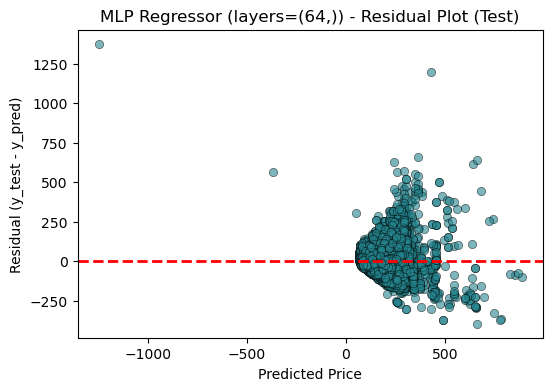

=== MLP Regressor (layers=(64, 32)) ===
Train -> R2: 0.596, MSE: 2227.52, RMSE: 47.20, MAE: 33.64
Test  -> R2: 0.588,  MSE: 2308.45,  RMSE: 48.05,  MAE: 33.85


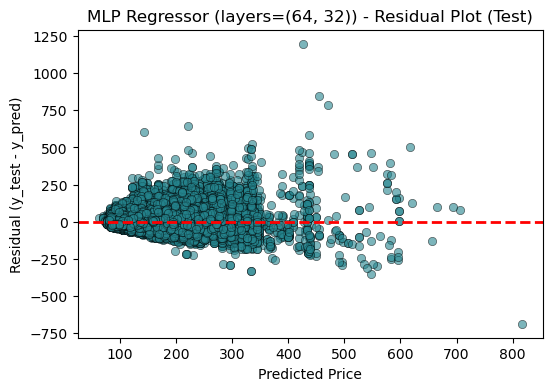

=== MLP Regressor (layers=(100, 50, 25)) ===
Train -> R2: 0.618, MSE: 2105.95, RMSE: 45.89, MAE: 32.96
Test  -> R2: 0.612,  MSE: 2177.21,  RMSE: 46.66,  MAE: 33.14


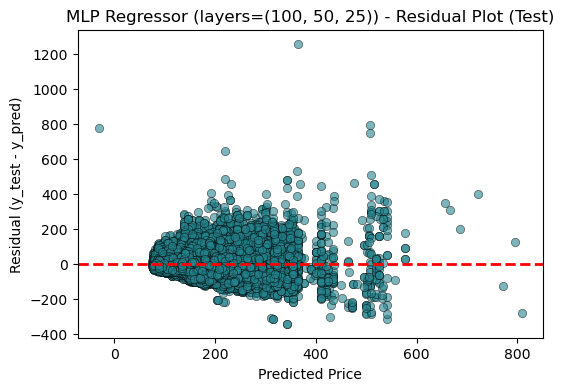

In [50]:
for hidden_layer_config in [(64,), (64, 32), (100, 50, 25)]:  # דוגמאות למבני רשת שונים
    mlp = MLPRegressor(hidden_layer_sizes=hidden_layer_config,  
                       max_iter=500,       # מספר epochs 
                       )
    model_name = f"MLP Regressor (layers={hidden_layer_config})"
    trained_mlp = train_and_evaluate_model(mlp, X_train, y_train, X_test, y_test, model_name)

### Conclusions:
The comparison between the models shows a slight improvement as more layers are added to the network. <br>
The model with the layers (100, 50, 25) achieved the best performance, with the highest R² and the lowest errors.

### XGBoost Regressor

In [51]:
# חלוקה אקראית ל-Train ו-Test ב-70-30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)

# 1. יצירת מודל XGBoost Regressor (מודל בסיסי עם פרמטרים ברירת מחדל)
model = xgb.XGBRegressor()

# 2. אימון המודל
model.fit(X_train, y_train)

# 3. תחזיות
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

Train R²: 0.681
Test R²: 0.672
Train MSE: 1762.86
Test MSE: 1823.0
Train RMSE: 41.99
Test RMSE: 42.7
Train MAE: 30.05
Test MAE: 30.51


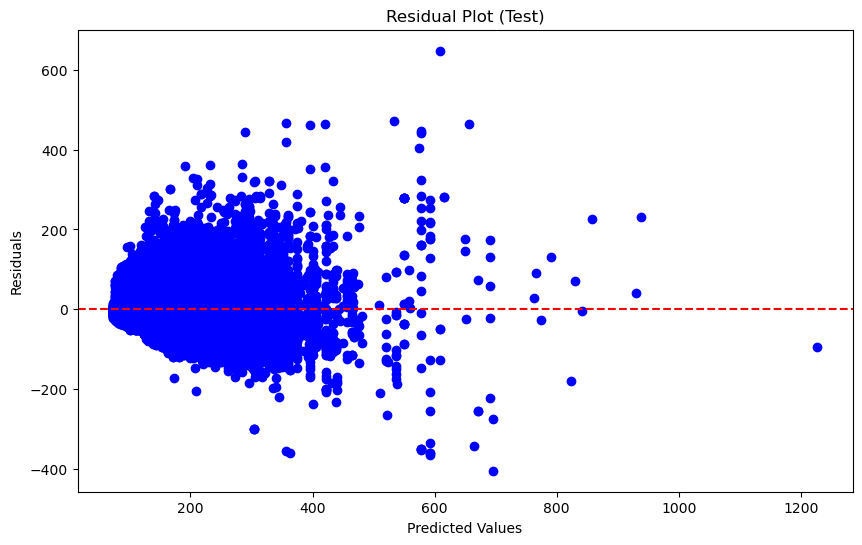

In [52]:
# 4. חישוב הביצועים
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

# חישוב ה-RMSE באופן ידני (שורש ה-MSE)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# 5. הדפסת הביצועים
print(f"Train R²: {round(train_r2, 3)}")
print(f"Test R²: {round(test_r2, 3)}")
print(f"Train MSE: {round(train_mse, 2)}")
print(f"Test MSE: {round(test_mse, 2)}")
print(f"Train RMSE: {round(train_rmse, 2)}")
print(f"Test RMSE: {round(test_rmse, 2)}")
print(f"Train MAE: {round(train_mae, 2)}")
print(f"Test MAE: {round(test_mae, 2)}")

# גרף Residual Plot עבור ה-Test
residuals = y_test - y_test_pred
plt.figure(figsize=(10,6))
plt.scatter(y_test_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--')
plt.title("Residual Plot (Test)")
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.show()


The model performs well overall, with good alignment between the training and test data, but there is room for improvement by experimenting with additional parameters. <br>
The Residual Plot shows that there is a region where the errors increase, which may indicate areas or features that the model is struggling to handle perfectly.

Parameters: {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7}
Train R²: 0.627
Test R²: 0.625
Train MSE: 2064.75
Test MSE: 2086.09
Train RMSE: 45.44
Test RMSE: 45.67
Train MAE: 32.28
Test MAE: 32.44


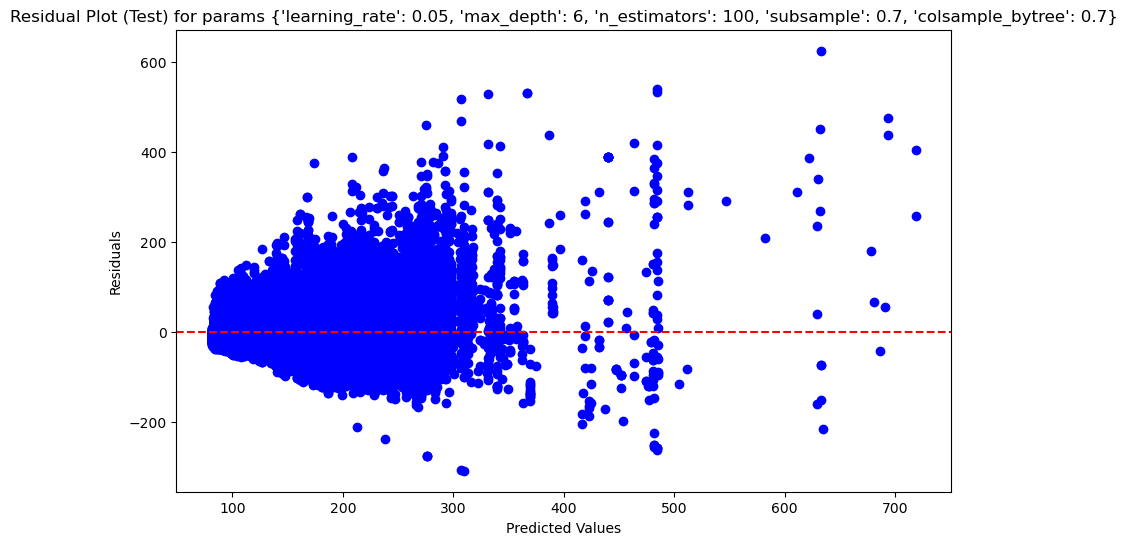

Parameters: {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85}
Train R²: 0.664
Test R²: 0.659
Train MSE: 1860.67
Test MSE: 1896.5
Train RMSE: 43.14
Test RMSE: 43.55
Train MAE: 30.79
Test MAE: 31.07


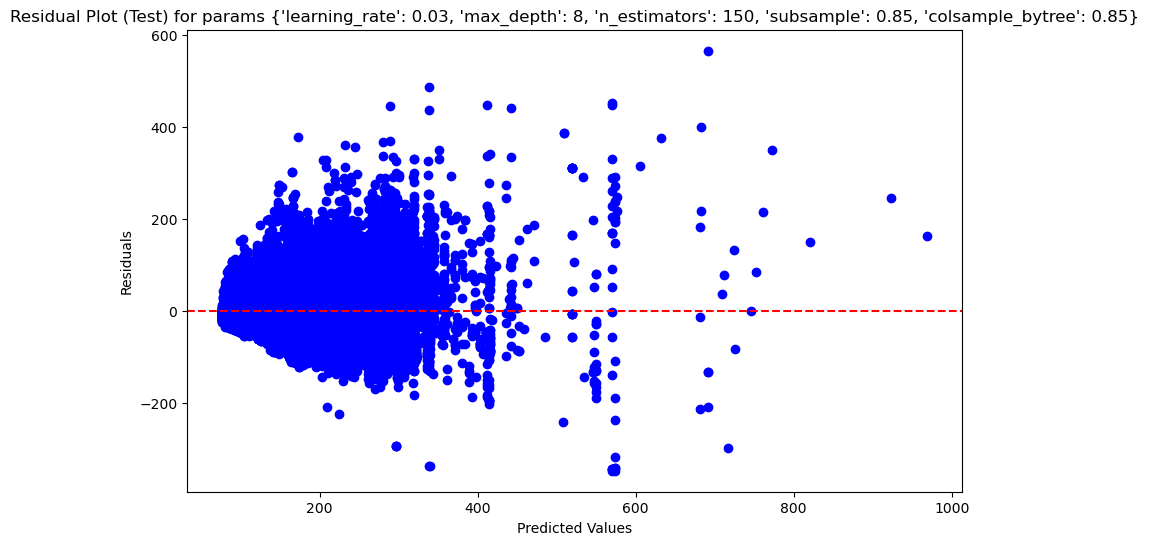

Parameters: {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
Train R²: 0.636
Test R²: 0.634
Train MSE: 2012.97
Test MSE: 2036.75
Train RMSE: 44.87
Test RMSE: 45.13
Train MAE: 32.06
Test MAE: 32.24


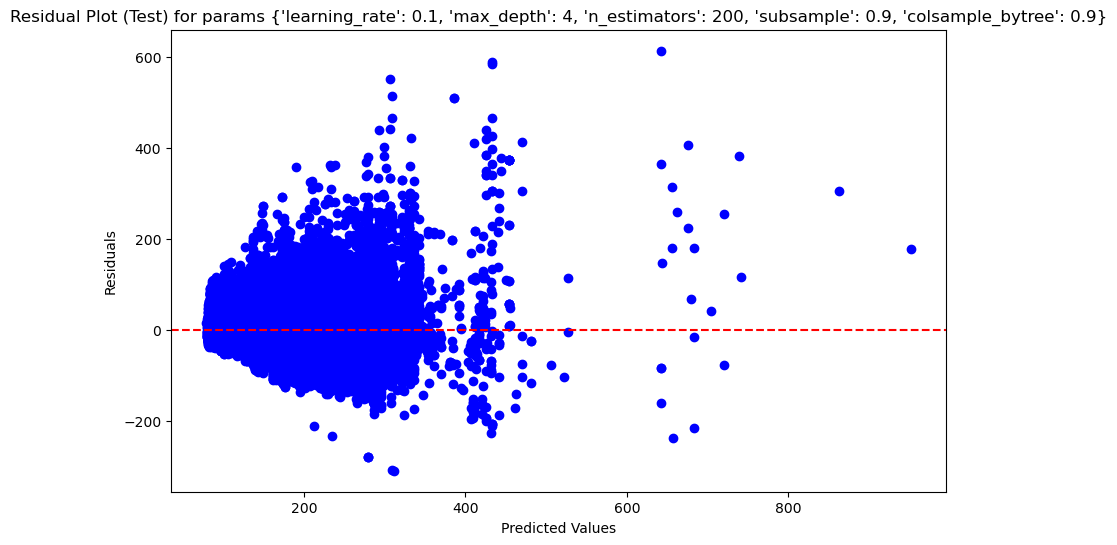

In [53]:
# 1. יצירת מודל XGBoost Regressor עם פרמטרים חדשים
params_list = [
    {'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.7, 'colsample_bytree': 0.7},
    {'learning_rate': 0.03, 'max_depth': 8, 'n_estimators': 150, 'subsample': 0.85, 'colsample_bytree': 0.85},
    {'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 200, 'subsample': 0.9, 'colsample_bytree': 0.9}
]

for params in params_list:
    # יצירת המודל עם הפרמטרים הנבחרים
    model = xgb.XGBRegressor(
        learning_rate=params['learning_rate'],
        max_depth=params['max_depth'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree']
    )

    # אימון המודל
    model.fit(X_train, y_train)

    # תחזיות
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # חישוב הביצועים
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # חישוב ה-RMSE באופן ידני
    train_rmse = np.sqrt(train_mse)
    test_rmse = np.sqrt(test_mse)

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    # הדפסת הביצועים
    print(f"Parameters: {params}")
    print(f"Train R²: {round(train_r2, 3)}")
    print(f"Test R²: {round(test_r2, 3)}")
    print(f"Train MSE: {round(train_mse, 2)}")
    print(f"Test MSE: {round(test_mse, 2)}")
    print(f"Train RMSE: {round(train_rmse, 2)}")
    print(f"Test RMSE: {round(test_rmse, 2)}")
    print(f"Train MAE: {round(train_mae, 2)}")
    print(f"Test MAE: {round(test_mae, 2)}")

    # גרף Residual Plot עבור ה-Test
    residuals = y_test - y_test_pred
    plt.figure(figsize=(10,6))
    plt.scatter(y_test_pred, residuals, color='blue')
    plt.axhline(0, color='red', linestyle='--')
    plt.title(f"Residual Plot (Test) for params {params}")
    plt.xlabel("Predicted Values")
    plt.ylabel("Residuals")
    plt.show()

## Hist Gradient Boosting

=== Hist Gradient Boosting ===
Train -> R2: 0.661, MSE: 1881.79, RMSE: 43.38, MAE: 31.22
Test  -> R2: 0.651,  MSE: 1929.72,  RMSE: 43.93,  MAE: 31.50


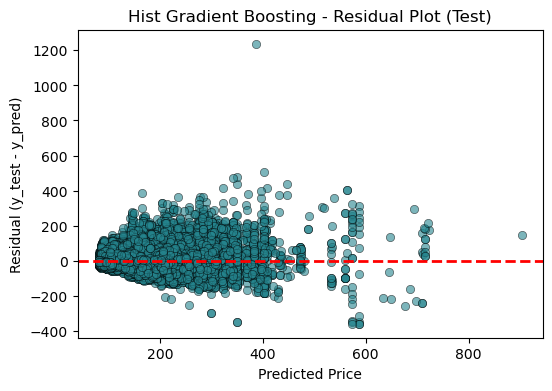

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# יצירת המודל הבסיסי
hgb = HistGradientBoostingRegressor()

# אימון ראשוני
hgb.fit(X_train, y_train)

rf_Hist_trained= train_and_evaluate_model(hgb,X_train,y_train,X_test,y_test,"Hist Gradient Boosting")

<style>
    .title {
        font-size: 24px;
        font-weight: bold;
        color:rgb(48, 168, 64);
        text-align: center;
        margin-bottom: 10px;
    }
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(64, 189, 48);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 15px;
    }
    .content {
        font-size: 19px;
        color:rgb(82, 168, 255);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">Hist Gradient Boosting - Model Performance Analysis</div>

<div class="subtitle">Introduction</div>
<div class="content">The model's performance was assessed using key regression metrics, and a residual plot was generated to analyze prediction errors.
</div>

<div class="section">Model Performance Metrics</div>

- **Training Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.661</span>
  - <strong>MSE:</strong> 1881.79
  - <strong>RMSE:</strong> 43.38
  - <strong>MAE:</strong> 31.22

- **Test Set:**
  - <strong>R² Score:</strong> <span class="highlight">0.651</span> (Minimal overfitting)
  - <strong>MSE:</strong> 1929.72
  - <strong>RMSE:</strong> 43.93
  - <strong>MAE:</strong> 31.50

<div class="section">Key Observations</div>

- The **R² score (~0.65) suggests that the model explains 65% of the variance** in the target variable, indicating a moderately strong predictive performance.
- **Low overfitting:** The train and test scores are very close, confirming that the model generalizes well.
- The **residual plot shows heteroscedasticity**, with larger residuals for higher predicted prices, meaning the model struggles more with expensive flights.
- A few **large positive residuals (600+) indicate underprediction**, while **negative residuals (-300 and below) suggest occasional overprediction**.
- The spread of residuals **widens for higher price predictions**, which could indicate missing features or non-linear trends.

<div class="section">Conclusions</div>

✅ The **model performs well overall** and generalizes across the dataset.  
✅ **Low overfitting**, with minimal train-test score differences.  
✅ **Heteroscedasticity is present**, meaning errors increase for higher price predictions.  
✅ **Outliers exist**, which might indicate data quality issues or limitations in model complexity.  


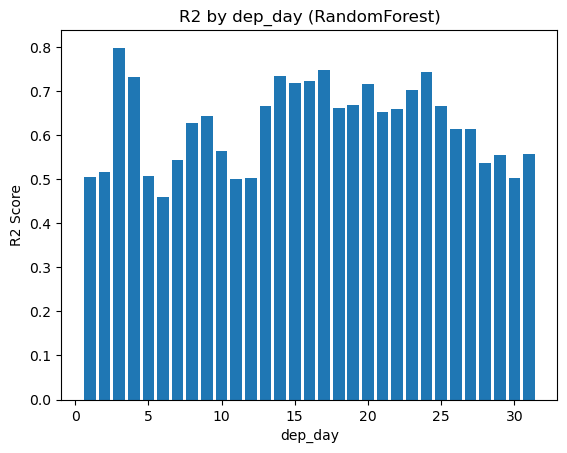

In [66]:
df_test = df.loc[y_test.index].copy()# מאחר ש-y_test הוא סדרה עם אינדקס - נחזיר ל-DataFrame המתאים
df_test["predicted_price_rf"] = rf_best_RFM.predict(X_test)

grouped = df_test.groupby("dep_day")
r2_by_day = []
days = []
for day_val, group_data in grouped:
    if len(group_data) > 1:
        r2_local = r2_score(group_data["Price"], group_data["predicted_price_rf"])
        r2_by_day.append(r2_local)
        days.append(day_val)

plt.bar(days, r2_by_day)
plt.xlabel("dep_day")
plt.ylabel("R2 Score")
plt.title("R2 by dep_day (RandomForest)")
plt.show()


# Analysis of R² by dep_day (RandomForest)
This bar plot represents how the R² score (coefficient of determination) varies based on dep_day (departure day) when using a Random Forest model.<br>
The R² score indicates how well the model explains the variance in the target variable for different departure days.



<style>
    .title {
        font-size: 22px;
        font-weight: bold;
        color:rgb(202, 202, 202);
        margin-bottom: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color:rgb(209, 209, 209);
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(252, 253, 255);
        margin-left: 15px;
        line-height: 1.6;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="title">Key Observations:</div>

<div class="section">1. Variability in Model Performance Across Days</div>
<div class="content">
    • The <strong>R² scores fluctuate significantly</strong> across different <strong>dep_day</strong> values.<br>
    • Some days achieve an R² score <span class="highlight">above 0.7</span>, meaning the model explains more than <strong>70% of the variance</strong>, while others drop closer to <span class="highlight">0.5</span> or lower, indicating poorer predictive accuracy.
</div>

<div class="section">2. Peaks and Dips in Predictive Performance</div>
<div class="content">
    • <strong>Highest R² (~0.8)</strong> occurs around <strong>dep_day = 3 and 14</strong>, suggesting that on these days, the model is highly effective at predicting outcomes.<br>
    • <span class="highlight">Sharp dips (below 0.5)</span> occur around <strong>dep_day = 7, 11, 30</strong>, meaning that on these specific days, the model struggles more with predictions.<br>
    • The pattern suggests <strong>certain departure days are easier to predict than others.</strong>
</div>


=== TTT division ===
Train -> R2: 0.615, MSE: 2128.87, RMSE: 46.14, MAE: 32.84
Test  -> R2: 0.610,  MSE: 2167.47,  RMSE: 46.56,  MAE: 32.95


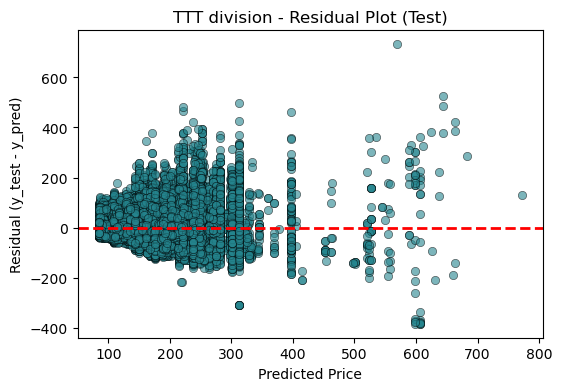

In [67]:
df_TTT_train = df[df["TTT"] <= 25].copy()
df_TTT_test  = df[df["TTT"] > 25].copy()

X_train_ttt = df_TTT_train[features]
y_train_ttt = df_TTT_train["Price"]
X_test_ttt  = df_TTT_test[features]
y_test_ttt  = df_TTT_test["Price"]

# גם כאן נרצה לעשות סקלינג חדש:
scaler_ttt = StandardScaler()
X_train_ttt_scaled = scaler_ttt.fit_transform(X_train_ttt)
X_test_ttt_scaled = scaler_ttt.transform(X_test_ttt)

# נאמן שוב Random Forest כמודל לדוגמה
rf_ttt = RandomForestRegressor(max_depth=8, n_estimators=100)
rf_ttt.fit(X_train_ttt_scaled, y_train_ttt)
rf_besto = train_and_evaluate_model(rf_ttt,X_train,y_train,X_test,y_test,"TTT division")

<style>
    .subtitle {
        font-size: 20px;
        font-weight: bold;
        color:rgb(77, 184, 143);
        margin-top: 10px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(97, 214, 146);
        margin-left: 10px;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
</style>

<div class="subtitle">TTT Division - Residual Analysis</div>

<div class="subtitle">Introduction</div>
<div class="content">
    The residual plot represents the performance of a <strong>Random Forest Regressor</strong> trained on data split based on <strong>TTT (Time to Travel)</strong>. The training set consists of data where TTT ≤ 25, while the test set includes TTT > 25.
</div>

<div class="section">Key Observations</div>

- **Residuals are mostly centered around zero for lower predicted prices (≤ 400),** but as prices increase, the spread of residuals grows significantly.
- There is **heteroscedasticity**, meaning the variance of residuals increases for higher predicted prices, indicating the model struggles with expensive flights.
- Several **large positive residuals (600+)** suggest the model <span class="highlight">underpredicts</span> prices in some cases.
- Similarly, some **negative residuals (-300 and below)** suggest occasional <span class="highlight">overpredictions</span>.
- There are **clusters of predictions** around **200-400** and **500-700**, indicating certain price ranges are more frequent in the dataset.

<div class="section">Conclusions</div>

✅ The model performs reasonably well for lower price predictions.  
✅ There is increasing <span class="highlight">error variability</span> for higher price predictions.  
✅ Large **underpredictions and overpredictions exist**, suggesting possible data biases or missing features.  

<style>
    .title {
        font-size: 26px;
        font-weight: bold;
        color:rgb(199, 199, 199);
        text-align: center;
        margin-bottom: 10px;
    }
    .subtitle {
        font-size: 22px;
        font-weight: bold;
        color: #2980b9;
        margin-top: 20px;
    }
    .section {
        font-size: 18px;
        font-weight: bold;
        color:rgb(79, 140, 202);
        margin-top: 15px;
    }
    .content {
        font-size: 16px;
        color:rgb(191, 223, 255);
        margin-left: 15px;
        line-height: 1.6;
    }
    .highlight {
        font-weight: bold;
        color: #e74c3c;
    }
    .key-findings {
        font-weight: bold;
        color: #27ae60;
    }
</style>

<div class="title">📊 Model Performance Analysis for Momondo and Kiwi (Individually) 🚀</div>

---

<div class="subtitle"> Momondo - Model Performance Analysis</div>

<div class="section"> Linear Regression</div>
<div class="content">
    <strong>Test R²:</strong> 0.305, <strong>MSE:</strong> 3812.84, <strong>RMSE:</strong> 61.75, <strong>MAE:</strong> 45.06<br>
     Performs <span class="key-findings">reasonably well</span>, suggesting some features follow a linear trend.<br>
     <span class="highlight">Fails to capture non-linear relationships</span>, reducing effectiveness.
</div>

<div class="section">🌲 Decision Tree (max_depth=3 and max_depth=5)</div>
<div class="content">
    <strong>Test R²:</strong> 0.398 (depth=3), <strong>0.460 (depth=5)</strong><br>
     <span class="key-findings">Outperformed Linear Regression</span>, meaning price prediction benefits from decision structures.<br>
     <span class="highlight">Risk of overfitting</span> when increasing depth further.
</div>

<div class="section">🌳 Random Forest Regressor</div>
<div class="content">
    <strong>Test R²:</strong> 0.65 - 0.67<br>
     <span class="key-findings">Handles feature interactions well</span> and generalizes better.<br>
     Computationally expensive and requires tuning.
</div>

<div class="section">Gradient Boosting & XGBoost</div>
<div class="content">
    <strong>Test R²:</strong> 0.66 - 0.67<br>
     <span class="key-findings">Best performing model</span>, indicating strong feature relationships.<br>
     Requires extensive hyperparameter tuning.
</div>

<div class="section">📈 Hist Gradient Boosting</div>
<div class="content">
    <strong>Test R²:</strong> 0.67<br>
     <span class="key-findings">Similar to XGBoost but more efficient</span>.<br>
     <span class="highlight">Less interpretable</span> than simpler models.
</div>

<div class="section">🔎 Momondo - Conclusions</div>
<div class="content">
     <span class="key-findings">Decision Trees and Ensemble models outperform simpler models</span>.<br>
     <span class="key-findings">Hist Gradient Boosting provides a balance of efficiency and accuracy.</span><br>
     Linear Regression struggles due to non-linearity in price trends.
</div>

---

🔹 **Final Thoughts:**  
- **Momondo has more structured pricing trends**, allowing simpler models to perform better.  
- **Kiwi data requires advanced models like XGBoost and Hist Gradient Boosting.**  
- **Ensemble models (Boosting and Random Forest) dominate performance across both datasets.**  

